# Introduction

In this notebook I classify a set of tweets made by US politicians as being made by either a republican or a democrat.
I use a small CNN architecture, allowing short explanations to be displayed alongside the prediction.

# Read Data

## Read and Split Data

In [1]:
import pandas as pd

tweets_df = pd.read_csv('data/us_politician_tweets.csv')

tweets_df['target'] = tweets_df['party'].apply(lambda x: x == 'democrat')

C:\Users\Gustav\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Pre-process data

In [2]:
vocab = {}

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopwords = set(stopwords.words())

import re

def process_tweet(tweet):
    
    tweet = str(tweet)
    # Lower Case
    tweet = tweet.lower()
    
    # Remove concluding URL
    tweet = re.sub(r' *https:\/\/t.co\/\w+$', '', tweet)
    
    # Replace other URLs with url tag
    tweet = re.sub(r'https?:.*?\s', 'url', tweet)
    
    # Replace carriage return and linebrak with space
    tweet = re.sub(r'[\r\n]', ' ', tweet)
    
    # Remove emoticons
    tweet = re.sub(r'&amp;', '', tweet)
    
    # Remove punctuation
    tweet = re.sub(r'[.,:;?!"]', ' ', tweet)
    
    # Tokenize by whitespace
    tweet = word_tokenize(tweet)#.split(" ")
    
    # Remove
    
    tweet = [tok for tok in tweet if tok != '' and tok not in stopwords]
    
    return tweet

def extend_vocab(tweet):
    tweet = process_tweet(tweet)
    for word in tweet:
        try:
            vocab[word] += 1
        except KeyError:
            vocab[word] = 1

## Tokenize Data

In [3]:
tweets_df['tokenized_tweet'] = tweets_df['tweet'].apply(process_tweet)

In [4]:
from functools import reduce

n_sentences = len(tweets_df)
n_tokens = reduce(lambda x, y: x + len(y), tweets_df.loc[:,'tokenized_tweet'].values, 0)

print("The training set contains {} sentences and {} tokens".format(n_sentences, n_tokens))

The training set contains 174740 sentences and 3007148 tokens


## Construct token correction mapping
In an attempt to allign as many tokens as possible in the raw data to tokens in GloVe I will construct a dictionary with conversions, which I will add on to iteratively.

Start of with a mapping where the target of all initial tokens is unkowns: `None`.

In [5]:
%%time
token_mapping = {}
token_counts = {}
for sentence in tweets_df.loc[:,'tokenized_tweet']:
    for tok in sentence:
        if tok not in token_mapping:
            token_mapping[tok] = None
            token_counts[tok] = 1
        else:
            token_counts[tok] += 1

Wall time: 1.64 s


In [6]:
print("There are %d unique tokens in the unprocessed data" % len(token_mapping))

There are 136049 unique tokens in the unprocessed data


# Glove Embeddings

I will opt to use the 100 dimensional Glove 6B data. My vocabulary will be exactly the words inside the pretrained model.

In [7]:
import os.path

In [8]:
import numpy as np

In [9]:
glove_path = 'C:/Users/Gustav/Data Science/glove/glove.6B/glove.6B.100d.txt'
embeddings = {}
token_index = {}
index_token = {}
embedding_dims = 100
with open(glove_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        tok, *vec = line.split()
        embeddings[tok] = np.array(vec, dtype='float32')
        # Reserve index 0 for padding
        token_index[tok] = i + 1
        index_token[i+1] = tok

# Allign Comments to GloVe

In [10]:
import re
import tqdm
import string

def allign_to_vocab(vocab, mapping, token_counts, n_tokens):
    
    # Allign directly
    mapping = allign_with_func(mapping, vocab, direct_allignment)
    oov = find_oov(mapping)
    oov_percent = 100 * sum([token_counts[tok] for tok in oov]) / n_tokens
    print("%d OOV tokens before pre processing (%.3f%% of all tokens in the data set)" % (len(oov), oov_percent))
    
    # Allign by replacing URL's with 'url'
    mapping = allign_with_func(mapping, vocab, convert_url)
    oov = find_oov(mapping)
    oov_percent = 100 * sum([token_counts[tok] for tok in oov]) / n_tokens
    print("%d OOV tokens after replacing urls with 'url' (%.3f%% of all tokens in the data set)" % (len(oov), oov_percent))
    
    # Allign by converting to word within 1 Levensthein Damerau distance
    mapping = allign_with_func(mapping, vocab, find_one_neighbour)
    oov = find_oov(mapping)
    oov_percent = 100 * sum([token_counts[tok] for tok in oov]) / n_tokens
    print("%d OOV tokens after spelling correction (%.3f%% of all tokens in the data set)" % (len(oov), oov_percent))
    
    return mapping

def find_oov(mapping):
    oov = []
    for tok, target in mapping.items():
        if not target:
            oov.append(tok)
    return oov

def find_targets(oov, allignment_func, vocab):
    targets = []
    print("Applying function to oov tokens:")
    for tok in tqdm.tqdm(oov):
        targets.append(allignment_func(tok, vocab))
    return targets

def allign_with_func(mapping, vocab, func):
    oov = find_oov(mapping)
    oov_targets = find_targets(oov, func, vocab)
    for tok, target in zip(oov, oov_targets):
            mapping[tok] = target
    return mapping

def direct_allignment(token, vocab):
    if token in vocab:
        return token
    else:
        return None
    
     
def convert_url(token, vocab):
    # Match words starting with www., http:// or https://
    if re.match(r'^(?:https{0,1}\:\/\/.*|www\.*)', token):
        return "url"
    else:
        return None

# Checks for vocabulary words within 1 Damerau Levenstein distance and returns the first match
# Logic inspired by http://norvig.com/spell-correct.html
def find_one_neighbour(word, vocab):
    
    if len(word) <= 2:
        return None
    
    ascii_vocab = string.ascii_lowercase
    
    # Tuples with all possible splits of word
    splits = [(word[:i], word[i:]) for i in range(len(word))]
    
    # All words generated by deleting one character
    for L, R in splits:
        candidate = L + R[1:] if R else None
        if candidate in vocab:
            return candidate
    # All words generated by swapping two characters in word
    for L, R in splits:    
        candidate = L + R[1] + R[0] + R[2:] if len(R) > 1 else None
        if candidate in vocab:
            return candidate
    # All words generated by inserting a character in word
    for L, R in splits:
        for c in ascii_vocab:    
            candidate = L + c + R 
            if candidate in vocab:
                return candidate
    # All words generated by replacing a character in word
    for L, R, in splits:
        for c in ascii_vocab:    
            candidate = L + c +R[1:] if R else None
            if candidate in vocab:
                return candidate
        
    return None
    

In [11]:
%%time
token_mapping = allign_to_vocab(embeddings, token_mapping, token_counts, n_tokens)

Applying function to oov tokens:


100%|█████████████████████████████████████████████████████████████████████| 136049/136049 [00:00<00:00, 1002327.16it/s]


84775 OOV tokens before pre processing (8.473% of all tokens in the data set)
Applying function to oov tokens:


100%|████████████████████████████████████████████████████████████████████████| 84775/84775 [00:00<00:00, 538863.21it/s]


84772 OOV tokens after replacing urls with 'url' (8.473% of all tokens in the data set)
Applying function to oov tokens:


100%|██████████████████████████████████████████████████████████████████████████| 84772/84772 [00:24<00:00, 3438.25it/s]


71791 OOV tokens after spelling correction (6.777% of all tokens in the data set)
Wall time: 25.4 s


How frequent are OOV tokens?

In [12]:
oov = find_oov(token_mapping)
oov_count = 0
for tok in oov:
    oov_count += token_counts[tok]

print("%d tokens in the data, thats %.3f%% of all tokens" % (oov_count, 100 * oov_count / n_tokens))

203804 tokens in the data, thats 6.777% of all tokens


In [13]:
oov[:25]

['repspier',
 'courageous—the',
 'gunsafetynow',
 'champions—today',
 'speakerpelosi',
 'repthompson',
 '116thcongress',
 'constituents—and',
 'nothing—so',
 'getcovered',
 'co/6k23dqilqs',
 'optionbthere',
 'givingtuesday',
 'giffordscourage',
 'girlscouts',
 'amarch4ourlives',
 'kidsrights',
 'lucywins2018',
 'blakemycoskie',
 'endgunviolencetogether',
 'co/cw76mgus3u',
 'tourdetucson',
 'katiehobbs',
 'kyrstensinema',
 'veteransday']

Let's check what spelling mistakes we fixed.

In [14]:
fixed_spelling = {}
for tok, target in token_mapping.items():
    if tok != target and tok != 'url' and target:
        fixed_spelling[tok] = target
        

Let's just peek at some fixes.

In [15]:
for i, (tok, target) in enumerate(fixed_spelling.items()):
    if i == 500:
        break
    print("%s -> %s" % (tok, target))

hr8 -> r8
30pm -> 3pm
urlby -> urby
//t -> g/t
jahana -> jhana
va10 -> a10
90975 -> 9975
ca25 -> a25
blasey -> basey
dcrums -> drums
pa06 -> pax6
ld24 -> d24
mariodb -> mariadb
bookshopsc -> bookshops
ichri -> chri
czentennial -> centennial
anniv -> anni
9/3 -> 93
theirc -> their
dday -> day
uchicago -> chicago
kwollack -> wollack
-supported -> supported
dmiliband -> miliband
ministere -> ministre
regles -> reles
sanfran -> safran
zbig -> big
cdmx -> dmx
bad-ass -> badass
mi8 -> i8
dlcc -> lcc
cd-3 -> d-3
iapol -> apol
akgov -> argov
ld26 -> d26
r-ky -> roky
ks03 -> ks3
utpol -> utpal
ut-2 -> t-2
ia04 -> ea04
neleg -> nele
ld6 -> d6
arpx -> rpx
ar02 -> br02
15pm -> 5pm
cspan2 -> span2
indeed… -> indeed
work… -> work
fy2000 -> f2000
-mexico -> mexico
800k -> 80k
c-span2 -> c-span
-supplied -> supplied
amdt -> mdt
cuidar -> cuidad
jakelin -> wakelin
caal -> aal
góméz -> gómez
precupa -> preocupa
faltar -> altar
verlas -> velas
difícil -> dificil
cir- -> cir
¡no -> no
¡la -> la
¿necesita 

A lot of these fixes just remove some uncessesary character in the original token, such as a hashtag, or `(opinion -> opinion`

However, some of these fixes are not propper spelling fixes, like `3671 -> 671`. I will accept them anyway though, as I think they will make little difference.

## Apply the data corrections

In [16]:
def correct_tok(tok, mapping):
    target = mapping[tok]
    
    return target if target else 'unk'

In [17]:
tweets_df.loc[:,'tokenized_tweet'] = tweets_df.loc[:,'tokenized_tweet'].apply(lambda s: [correct_tok(tok, token_mapping) for tok in s])

Check sequence lengths

In [18]:
tweets_df.loc[:,'seq_len'] = tweets_df.loc[:,'tokenized_tweet'].apply(len)

tweets_df.loc[:,'seq_len'].describe()

count    174740.000000
mean         17.209271
std           8.127515
min           0.000000
25%          11.000000
50%          17.000000
75%          24.000000
max         112.000000
Name: seq_len, dtype: float64

Remove empty tweets.

In [19]:
tweets_df = tweets_df.loc[tweets_df['seq_len'] > 0]

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [21]:
binned_seq_lens = np.bincount(tweets_df.loc[:,'seq_len'])
n_bins = len(binned_seq_lens)
binned_seq_lens_acu = np.cumsum(binned_seq_lens)

In [22]:
len(binned_seq_lens_acu[:1000])

113

Text(0,0.5,'Percentage of sentences same length or longer than X')

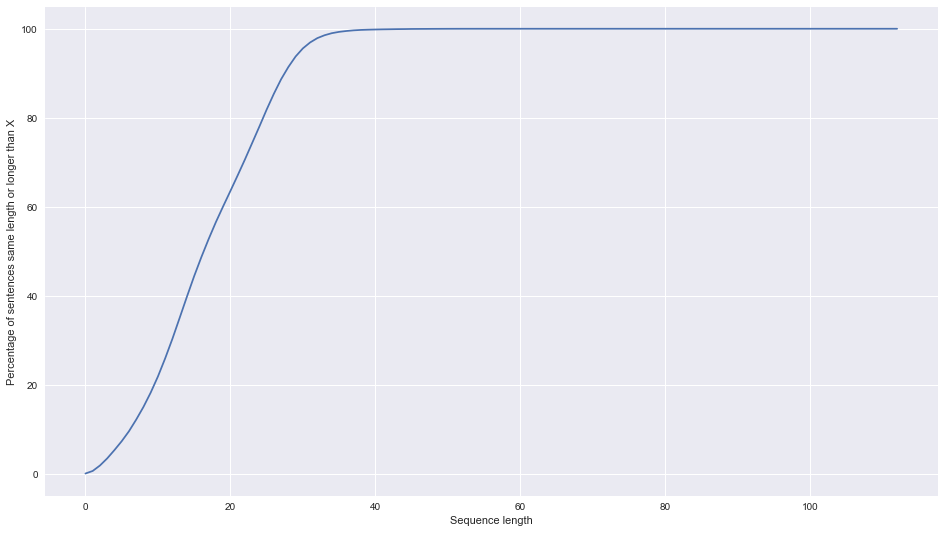

In [23]:
f, ax = plt.subplots(figsize=(16,9))
ax.plot(np.arange(n_bins), 100 * binned_seq_lens_acu/len(tweets_df))
ax.set_xlabel('Sequence length')
ax.set_ylabel('Percentage of sentences same length or longer than X')

In [24]:
binned_seq_lens_acu[30]/len(tweets_df)

0.9558219513459644

Almost all sequences are shorter than 30 words, so I could improve training performance by setting a max sequence length of 30.

## Convert embeddings to tensor

In [25]:
import torch

In [26]:
embedding_weights = torch.zeros(len(embeddings) + 1, embedding_dims)
for tok, i in token_index.items():
    embedding_weights[i] = torch.from_numpy(embeddings[tok])

In [27]:
import numpy as np

def split_party_authors(df):
    author_tweets = df.groupby('twitter_id')
    author_tweets = author_tweets.count()
    author_tweets['cumsum'] = author_tweets['tweet'].cumsum()
    author_tweets['%'] = author_tweets['cumsum'] / author_tweets['tweet'].sum()
    
    train_id = np.argmax(author_tweets['%'].values >= .7)
    val_id = np.argmax(author_tweets['%'].values >= .85)
    
    train_authors = list(author_tweets.iloc[:train_id].index.values)
    val_authors = list(author_tweets.iloc[train_id:val_id].index.values)
    test_authors = list(author_tweets.iloc[val_id:].index.values)
    
    return train_authors, val_authors, test_authors

def split_data(df):
    
    democrat_df = df[df['party'] == 'democrat']
    republican_df = df[df['party'] == 'republican']
    
    democrat_train, democrat_val, democrat_test = split_party_authors(democrat_df)
    republican_train, republican_val, republican_test = split_party_authors(republican_df)
    
    train_authors = democrat_train + republican_train
    val_authors = democrat_val + republican_val
    test_authors = democrat_test + republican_test
    
    return df.loc[df['twitter_id'].apply(lambda x: x in train_authors)], df.loc[df['twitter_id'].apply(lambda x: x in val_authors)], df.loc[df['twitter_id'].apply(lambda x: x in test_authors)]
    

In [28]:
train_df, val_df, test_df = split_data(tweets_df)

## Shuffle Data

In [29]:
train_df = train_df.sample(frac=1)
val_df = val_df.sample(frac=1)
test_df = test_df.sample(frac=1)

## Convert data to tensors

In [30]:
def tokenized2tensor(tokenized_sentence, token_index):
    return torch.from_numpy(np.asarray([token_index[tok] for tok in tokenized_sentence])).long()

In [31]:
X_train = [tokenized2tensor(sentence, token_index) for sentence in train_df.loc[:,'tokenized_tweet']]
y_train = torch.from_numpy(train_df.loc[:,'target'].astype(int).values)

In [32]:
X_val = [tokenized2tensor(sentence, token_index) for sentence in val_df.loc[:,'tokenized_tweet']]
y_val = torch.from_numpy(val_df.loc[:,'target'].astype(int).values)

In [33]:
X_test = [tokenized2tensor(sentence, token_index) for sentence in test_df.loc[:,'tokenized_tweet']]
y_test = torch.from_numpy(test_df.loc[:,'target'].astype(int).values)

## Pad the Data

In [34]:
class PaddedAndClipGenerator():
    def __init__(self, x_set, y_set = None, batch_size = 126, max_len = 100, shuffle_batches=False):
        
        self.max_len = max_len
        self.reshuffle = shuffle_batches
        
        if y_set is not None:
            self.has_label = True
        else:
            self.has_label = False
            
        self.batch_size = batch_size
        if self.has_label:
            self.x, self.y, self.sequence_lengths = [], [], []
        else:
            self.x, self.sequence_lengths = [], []
        # Pad Data so all batches have sequences of equal length
        for idx in range(int(np.ceil(len(x_set) / float(self.batch_size)))):
            batch_x = x_set[idx * self.batch_size:(idx + 1) * self.batch_size]
            
            # The input is sorted so the first sequence is the longest
            batch_seq_len = min([len(batch_x[0]), self.max_len])
            batch_x_pad = torch.zeros(len(batch_x), batch_seq_len, dtype=torch.long)
            batch_sequence_lengths = torch.Tensor(list(map(len, batch_x))).int()
            
            for i, (seq, seq_len) in enumerate(zip(batch_x, batch_sequence_lengths)):
                seq_len = min([batch_seq_len, seq_len])
                batch_x_pad[i,:seq_len] = seq[:seq_len] 
            
            self.x.append(batch_x_pad)
            
            if self.has_label:
                batch_y = y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
                self.y.append(batch_y)
        self.shuffle_batches()
            
            
    def shuffle_batches(self):
        idx = np.random.permutation(len(self.x))
        self.x = [self.x[i] for i in idx]
        self.y = [self.y[i] for i in idx]
    
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        if self.has_label:
            return self.x[idx], self.y[idx]
        else:
            return self.x[idx]

In [35]:
def sort_sequences(X, y):
    seq_lens = [len(x) for x in X]
    idx = np.argsort(seq_lens)[::-1]
    X = [X[i] for i in idx]
    y = torch.Tensor([y[i] for i in idx])
    return X, y

In [36]:
X_train, y_train = sort_sequences(X_train, y_train)
X_val, y_val = sort_sequences(X_val, y_val)
X_test, y_test = sort_sequences(X_test, y_test)

In [37]:
train_padded = PaddedAndClipGenerator(X_train, y_train, batch_size=126, shuffle_batches = True, max_len=30)
val_padded = PaddedAndClipGenerator(X_val, y_val, batch_size=126, shuffle_batches = True, max_len=30)
test_padded = PaddedAndClipGenerator(X_test,y_test,  batch_size=126, shuffle_batches = True, max_len=30)

# CNN

## Model

In [38]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import average_precision_score
from tqdm import tqdm_notebook

import copy
class CNNClassifierSignalInspection(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_weights, conv_kernels = [3]):
        super(CNNClassifierSignalInspection, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_weights.size(1)
        self.n_conv_layers = len(conv_kernels)
        
        # Pre-trained embeddings, allowed to be refit during training
        self.embedding = nn.Embedding(*embedding_weights.shape, _weight=embedding_weights, padding_idx=0)
        
        # Convolutional Layers (Padding to ensure we can process sequences shorter than the kernel)
        self.conv_layers = []
        
        for kernel in conv_kernels:
            self.conv_layers.append(nn.Conv1d(self.embedding_size, self.hidden_size, kernel, padding=kernel-1))
        
        # Fully Connected
        self.fc = nn.Linear(self.hidden_size * self.n_conv_layers, 1)
        
        
    def forward(self, batch):
        
        # BxL
        
        # Embeddings
        embedded = self.embedding(batch).permute([0, 2, 1]) # BxCxL
        
        # Convolutions
        conv_outputs = []
        for conv in self.conv_layers:
            x = conv(embedded) #BxCxL
            x = F.relu(x) #BxCxL
            x = F.max_pool1d(x, kernel_size=x.size(2)).reshape(batch.size(0), -1) #BxC
            conv_outputs.append(x)
        
        x = torch.cat(conv_outputs, dim=1)
        
        # Fully connected
        x = self.fc(x) #B
        
        # Fully Connected
        #x = torch.sigmoid(x) #B
        return x
    
    def interpret_prediction(self, sequence, id2token):
        
        # BxL
        sequence = sequence.reshape(1,-1)
        
        with torch.no_grad():
            # Embeddings
            embedded = self.embedding(sequence).permute([0, 2, 1]) # BxCxL

            # Convolutions
            conv_outputs = []
            max_signal = []
            for conv in self.conv_layers:
                x = conv(embedded) #BxCxL
                x = F.relu(x) #BxCxL
                max_signal.append(x.argmax(2))
                x = F.max_pool1d(x, kernel_size=x.size(2)).reshape(sequence.size(0), -1) #BxC
                conv_outputs.append(x)

            x = torch.cat(conv_outputs, dim=1)
            
            #return max_signal
            
            impact = self.fc.weight * x
            conv_kerlnels = [conv.kernel_size[0]  for conv in self.conv_layers]
            activation_words = [self._ngrams_from_activation_ids(id2token, dim[0].tolist(), sequence, n) for dim, n in zip(max_signal, conv_kerlnels)]

            # Fully Connected
            #x = torch.sigmoid(x) #B
            return impact[0].numpy(), np.array(functools.reduce(lambda x,y: x+y, activation_words)), torch.sigmoid(self.fc(x))
    
    def _ngrams_from_activation_ids(self, id2token, activation_start_ids, sequence, n):
        
        offset = n-1
        
        ngram_ids = [[word_id.item() for word_id in sequence[0,start_id + offset:start_id+n+offset ]] for start_id in activation_start_ids]
        
        return [" ".join([id2token[word_id] for word_id in ngram]) for ngram in ngram_ids]
        

## Training Function

In [39]:
# Function inspired by https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, train_generator, optimizer, criterion, dev_generator=None, epochs = 2):
    
    # Only enter the validation state if there is a validation_loader
    phases = ['train']
    data_dict = {'train' : train_generator} 
    if dev_generator:
        phases.append('val')
        data_dict['val'] = dev_generator
        
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)

        for phase in phases:
            
            data = data_dict[phase]
            
            # Only update model weights based on the training data
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            comments_processed = 0
            epoch_probas = []
            epoch_labels = []
            
            pbar = tqdm_notebook(data, total = len(data))
            for seq, labels in pbar:

                optimizer.zero_grad()
                
                # Only track history during training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(seq).reshape(-1)
                    loss = criterion(outputs, labels)
                    probas = torch.sigmoid(outputs)
                    predictions = probas > .5
                    
                    # Only perform backpropagation during training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Save statistics
                running_loss += loss.item()
                # Only count correct classifications when the label is not padding
                running_corrects += torch.sum(predictions == labels.data.byte())
                comments_processed += len(seq)
                
                epoch_probas += [prob.item() for prob in probas]
                epoch_labels += list([label.item() for label in labels.byte()])
                
                pbar.set_description("APS: %.3f" % average_precision_score(epoch_labels, epoch_probas))
                
                
            epoch_loss = running_loss / comments_processed
            epoch_acc = running_corrects.item() / comments_processed
            epoch_average_precision_score = average_precision_score(epoch_labels, epoch_probas)
            
            if data.reshuffle:
                # Shuffle the batch order so it's not the same next epoch
                data.shuffle_batches()
            
            print('{} Loss: {:.4f} Acc: {:.4f}, APS: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_average_precision_score))
                
            

In [40]:
cnn_signal_inspection_small = CNNClassifierSignalInspection(embedding_weights.size(0), 10, embedding_weights, [1, 2])

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_signal_inspection_small.parameters())

In [41]:
train_model(cnn_signal_inspection_small, train_padded, optimizer, criterion, dev_generator=val_padded)

Epoch 1/2
----------


A Jupyter Widget


train Loss: 0.0051 Acc: 0.6339, APS: 0.6945


A Jupyter Widget


val Loss: 0.0051 Acc: 0.6303, APS: 0.6883
Epoch 2/2
----------


A Jupyter Widget


train Loss: 0.0043 Acc: 0.7350, APS: 0.8164


A Jupyter Widget


val Loss: 0.0050 Acc: 0.6459, APS: 0.7102


Based on deleted experiments, I have verified that more epochs lead to worse validation set performance.

In [42]:
import functools

### Eval model

In [43]:
def predict_with_model(model, generator):
    
    data = generator
    model.eval()

    running_corrects = 0
    comments_processed = 0
    all_probas = []
    all_labels = []

    pbar = tqdm_notebook(data, total = len(data))
    for seq, labels in pbar:

        with torch.set_grad_enabled(False):
            outputs = model(seq).reshape(-1)
            probas = torch.sigmoid(outputs)
            predictions = probas > .5

        # Save statistics
        running_corrects += torch.sum(predictions == labels.data.byte())
        comments_processed += len(seq)

        all_probas += [prob.item() for prob in probas]
        all_labels += list([label.item() for label in labels.byte()])

        pbar.set_description("APS: %.3f" % average_precision_score(all_labels, all_probas))


    return all_probas, all_labels

In [44]:
probas, labels = predict_with_model(cnn_signal_inspection_small, test_padded)

A Jupyter Widget

In [45]:
test_df_inspection = pd.DataFrame(data=np.array([probas, labels]).T, columns=['Probability', 'Label'])
test_df_inspection['Predicted Label'] = test_df_inspection['Probability'] > .5

In [46]:
test_df_inspection['Correct'] = test_df_inspection['Label'] == test_df_inspection['Predicted Label']

In [47]:
test_df_inspection['Correct'].sum() / len(test_df_inspection)

0.6218305855599773

In [48]:
sns.set_style('whitegrid')

C:\Users\Gustav\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


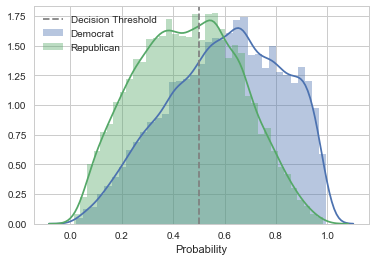

In [49]:
f, ax = plt.subplots(figsize=(6,4))
sns.distplot(test_df_inspection.loc[test_df_inspection['Label'] == True, 'Probability'],ax=ax)
sns.distplot(test_df_inspection.loc[test_df_inspection['Label'] == False, 'Probability'],ax=ax)
ax.axvline(.5, color='grey', linestyle='--')

ax.legend(['Decision Threshold' , 'Democrat', 'Republican'])
#ax.set_title('Distribution of Predictions by Gold Standard Class')

### Inspect Filters

In [50]:
def print_most_influential(tweet_row, k):
    
    activations, activation_words, proba = cnn_signal_inspection_small.interpret_prediction(tokenized2tensor(tweet_row['tokenized_tweet'], token_index), id2token=index_token)
    
    sorted_idx = np.argsort(activations)
    
    democrat = proba.item() > .5
    
    print(tweet_row['tweet'])
    print("Prediction %s with certainty %.2f (%s)" % ("Democrat" if democrat else "Republican", proba if democrat else 1 - proba, "correct" if democrat == tweet_row['target'] else "incorrect"))
    print("Most impactful words:")
    print(set(activation_words[sorted_idx][-k:][::-1]) if democrat else set(activation_words[sorted_idx][:k]))

In [51]:
def find_most_influential(tweet_row, k=5):
    
    activations, activation_words, proba = cnn_signal_inspection_small.interpret_prediction(tokenized2tensor(tweet_row['tokenized_tweet'], token_index), id2token=index_token)
    
    sorted_idx = np.argsort(activations)
    
    democrat = proba.item() > .5
    
    return proba.item(), list(zip(activation_words[sorted_idx][-k:][::-1], activations[sorted_idx][-k:][::-1])) if democrat else list(zip(activation_words[sorted_idx][:k], activations[sorted_idx][:k]))

In [52]:
def plot_interpretation(activation_words, activations, proba, tweet):
    
    sorted_idx = np.argsort(activations)
    
    f, ax = plt.subplots(figsize=(16,9))
    sns.barplot(x=np.arange(len(activations)), y=activations[sorted_idx])
    ax.set_title("Democrat with probability %.3f" % proba)
    ax.set_xticklabels(activation_words[sorted_idx])
    plt.xticks(rotation=45)
    

In [53]:
cnn_signal_inspection_small.fc

Linear(in_features=20, out_features=1, bias=True)

In [54]:
for i in range(50):
    print_most_influential(test_df.iloc[25+ i], 5)
    print()

"We do not have Obama judges or Trump judges, Bush judges or Clinton judges...That independent judiciary is something we should all be thankful for."--Chief Justice John Roberts
Just so there's no confusion @POTUS (and Justice Kavanaugh)
https://t.co/oYY5PQsXOo
Prediction Republican with certainty 0.75 (correct)
Most impactful words:
{')', 'potus', 'obama', "'s confusion", 'independent judiciary'}

The Democrats, much as I suspected, have allocated no money for a new Wall. So imaginative! The problem is, without a Wall there can be no real Border Security - and our Country must finally have a Strong and Secure Southern Border!
Prediction Democrat with certainty 0.58 (incorrect)
Most impactful words:
{'strong secure', 'real border', 'suspected', 'real', 'finally strong'}

Successfully getting this legislation signed into law has a deep personal meaning for me, as I was a caregiver for my grandmother during her battle with Alzheimer’s disease. I am proud to be a part of the fight to comb

Prediction Democrat with certainty 0.60 (incorrect)
Most impactful words:
{'said', '@ unk', 'unk @', '@'}

Started the day thanking volunteers in the Naples victory office! Their hard work and dedication are why we’re going to have a big win tonight! https://t.co/BTm1qejxZ9
Prediction Republican with certainty 0.50 (correct)
Most impactful words:
{'office hard', 'hard', 'naples'}

Precinct One &amp; NBA/WNBA Retired Players Association @NBRPA_Houston hosted a Full Court Press Prep for Success #youth #basketball clinic today at #FinniganPark Community Center / YET. Check out ALL the pics here: https://t.co/qHKbBdygVi   #Houston #HarrisCounty https://t.co/rWEIffS4PN
Prediction Democrat with certainty 0.57 (correct)
Most impactful words:
{'/', 'youth', 'check pics', 'prep success', 'prep'}

China, the economy, trade and other @USTreasury priorities were the topics of my discussion on @CNNSitRoom today at the @MilkenInstitute global conference. https://t.co/gXVB2YjemY
Prediction Republican

Most impactful words:
{'', 'prolife', 'abortion', 'babies girls', '# prolife'}

President Trump’s continued reliance on falsehoods &amp; xenophobic anecdotes rather than facts are roadblocks to progress.
Prediction Democrat with certainty 0.93 (correct)
Most impactful words:
{'xenophobic', 'progress', 'reliance falsehoods', 'trump', 'falsehoods'}



In [55]:
res = []
for i in tqdm.tqdm(range(len(test_df))):
    res.append(find_most_influential(test_df.iloc[i]))


100%|███████████████████████████████████████████████████████████████████████████| 26385/26385 [01:07<00:00, 390.99it/s]


In [56]:
democratic_words = {}
republican_words = {}

for p, words in res:
    if p > .5:
        for word, activation in words:
            if word in democratic_words:
                democratic_words[word] += 1#abs(activation)
            else:
                democratic_words[word] = 1#abs(activation)    
    else:
        for word, activation in words:
            if word in republican_words:
                republican_words[word] += 1#abs(activation)
            else:
                republican_words[word] = 1#abs(activation)

In [57]:
import operator 

democrat_freq_counts = sorted(democratic_words.items(), key=operator.itemgetter(1), reverse=True)

republican_freq_counts = sorted(republican_words.items(), key=operator.itemgetter(1), reverse=True)

Print top lists in a format compatible with a latex table.

In [58]:
def print_freq_tex(democrat_freq_counts, republican_freq_counts, n):
    for i in range(n):
        print("%s&%s\\\\"%(democrat_freq_counts[i][0].replace('#', '\#'),republican_freq_counts[i][0].replace('#', '\#')))

In [59]:
print_freq_tex(democrat_freq_counts, republican_freq_counts, 26)

&\\
@ unk&great\\
unk&http\\
\# unk&\# unk\\
trump&@ unk\\
\#&america\\
health&nation\\
@&law\\
us&read\\
unk \#&senate\\
chicago&g/t unk\\
climate&state\\
one&birthday\\
http&potus\\
community&jobs\\
—&county\\
children&economy\\
unk @&passed\\
city&https\\
rights&news\\
families&tax\\
investigation&blessed\\
campaign&military\\
violence&years\\
shutdown&service\\
gun&unk\\


### Top Words in Certain Predictions

In [60]:
democratic_certain_words = {}
republican_certain_words = {}

c = 0

for p, words in res:
    if p < .15 or p > .85:
        c+= 1
    
        if p > .5:
            for word, activation in words:
                if word in democratic_certain_words:
                    democratic_certain_words[word] += 1#abs(activation)
                else:
                    democratic_certain_words[word] = 1#abs(activation)    
        else:
            for word, activation in words:
                if word in republican_certain_words:
                    republican_certain_words[word] += 1#abs(activation)
                else:
                    republican_certain_words[word] = 1#abs(activation)

In [61]:
democratic_certain_words = sorted(democratic_certain_words.items(), key=operator.itemgetter(1), reverse=True)

republican_certain_words = sorted(republican_certain_words.items(), key=operator.itemgetter(1), reverse=True)

In [63]:
print_freq_tex(democratic_certain_words, republican_certain_words, 26)

trump&\\
&great\\
health&ncga\\
climate&blessed\\
chicago&potus\\
\# unk&law\\
gun&\# unk\\
protections&read\\
violence&israel\\
enrollment&jobs\\
a3&@ unk\\
rights&nation\\
shutdown&economy\\
pre-existing&tax\\
@ unk&illegal\\
conditions&senate\\
aca&birthday\\
investigation&secure\\
children&conservative\\
plan&america\\
workers&passed\\
unk&god\\
democratic&military\\
lgbtq&heroes\\
healthcare&borders\\
equality&combat\\


# Comment

This run of the notebook yields different results from the run analysed in my report. Accuracy is slightly lower here, and the top lists of n-grams are not the same.